# Sistema de Recomendación de Cursos

## Introducción
Este notebook desarrolla un sistema de recomendación de cursos basado en técnicas de procesamiento de lenguaje natural (NLP). Usaremos el dataset de cursos que contiene información sobre los nombres de los cursos, habilidades requeridas, nivel de dificultad y la plataforma donde se ofrecen. Nuestro objetivo es recomendar cursos similares basados en la entrada del usuario.

### Librerias

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

## Cargar el Dataset
Cargaremos el dataset y exploraremos su estructura para comprender las variables disponibles.

In [7]:
courses_path = '../app/data/courses_cleaned_dataset.csv'
courses_data = pd.read_csv(courses_path)

In [8]:
# Explorar el dataset
print("\nPrimeras filas del dataset:")

courses_data.head()


Primeras filas del dataset:


,Course_Name,Level,Rating,Skills,Number of students,Platform
0,Data Engineer,1,4.6,"Data Modeling, Data Pipelines, Data Lakes, Spa...",98175,Udacity
1,Data Scientist,2,4.7,"Machine Learning, Deep Learning, Software Engi...",89044,Udacity
2,Data Analyst,1,4.6,"Data Wrangling, Matplotlib, Bootstrapping, Pan...",88873,Udacity
3,C++,1,4.6,"Data Structures &amp; Algorithms, Memory Manag...",86627,Udacity
4,Product Manager,0,4.7,"Product Strategy, Product Design, Product Deve...",99575,Udacity


In [9]:
print("\nInformación general del dataset:")
courses_data.info()


Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2377 entries, 0 to 2376
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Course_Name         2377 non-null   object 
 1   Level               2377 non-null   int64  
 2   Rating              2377 non-null   float64
 3   Skills              2377 non-null   object 
 4   Number of students  2377 non-null   int64  
 5   Platform            2377 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 111.6+ KB


### Quitarnos Duplicados

In [10]:
# Eliminar duplicados en el dataset base
courses_data = courses_data.drop_duplicates(subset='Course_Name').reset_index(drop=True)

### Distribucion de calificaciones

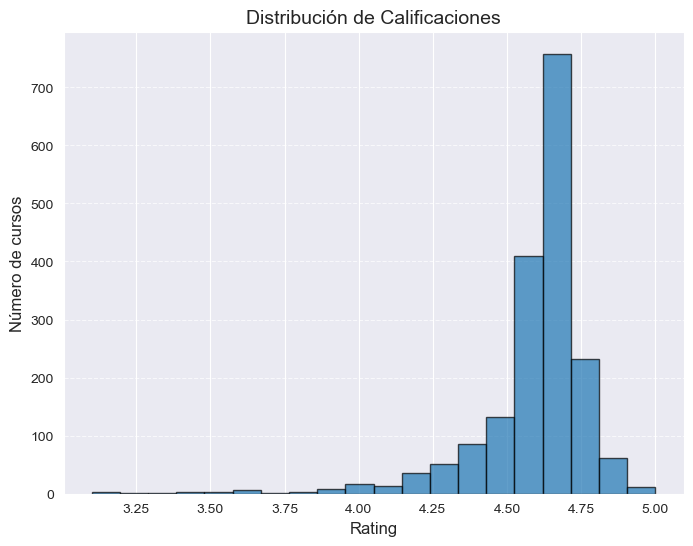

In [11]:
plt.figure(figsize=(8, 6))
plt.hist(courses_data['Rating'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribución de Calificaciones', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Número de cursos', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Cantidad de cursos por nivel de dificultad

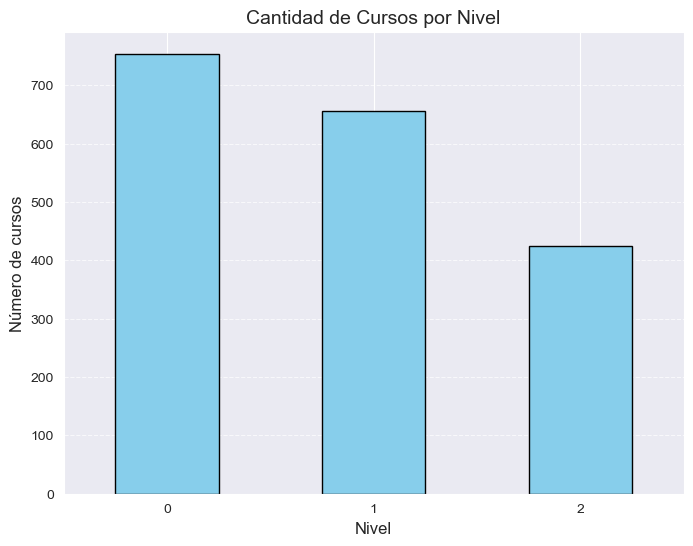

In [12]:
plt.figure(figsize=(8, 6))
courses_data['Level'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Cantidad de Cursos por Nivel', fontsize=14)
plt.xlabel('Nivel', fontsize=12)
plt.ylabel('Número de cursos', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.show()

### Popularidad (num de estudiantes)

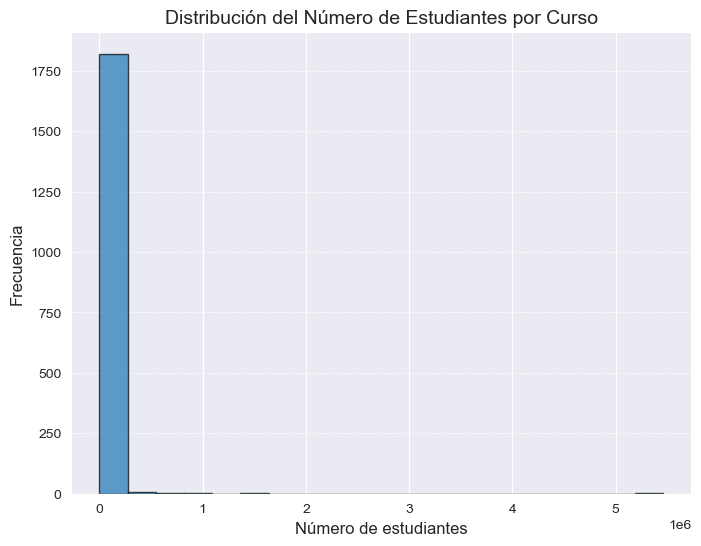

In [13]:
plt.figure(figsize=(8, 6))
plt.hist(courses_data['Number of students'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribución del Número de Estudiantes por Curso', fontsize=14)
plt.xlabel('Número de estudiantes', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Cantidad de Cursos por Plataforma

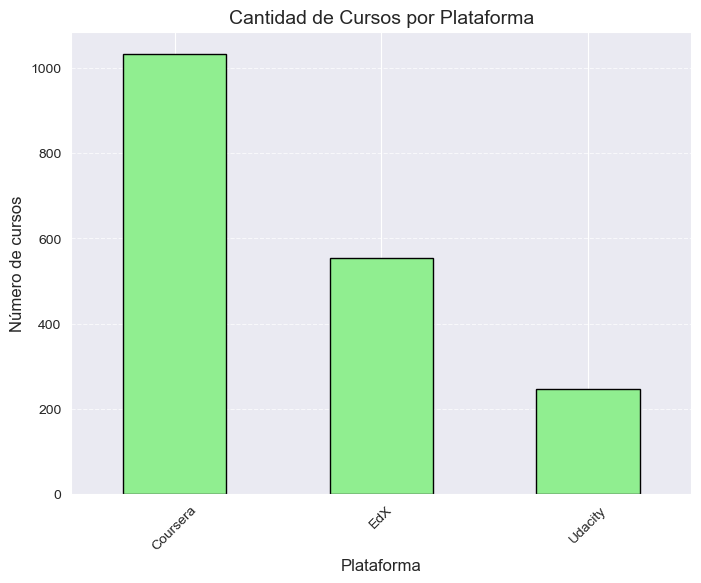

In [14]:
plt.figure(figsize=(8, 6))
courses_data['Platform'].value_counts().plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Cantidad de Cursos por Plataforma', fontsize=14)
plt.xlabel('Plataforma', fontsize=12)
plt.ylabel('Número de cursos', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

1. **Distribución de calificaciones**: Las calificaciones están concentradas en valores altos, con la mayoría de los cursos puntuados entre 4.5 y 5.0.

2. **Cantidad de cursos por nivel**: Hay más cursos en el nivel intermedio (nivel 1) que en los niveles básico (0) y avanzado (2).

3. **Popularidad de los cursos**: La distribución del número de estudiantes por curso muestra que hay cursos altamente populares, pero también muchos con menor inscripción.

4. **Cantidad de cursos por plataforma**: Algunas plataformas ofrecen una mayor variedad de cursos en comparación con otras.

# Preprocesamiento del texto en la columna "Skills"
La columna Skills contiene información textual sobre las habilidades desarrolladas en cada curso. Para usar esto en un modelo de recomendación basado en contenido, convertiremos este texto en una representación numérica que capture el significado subyacente. Vamos paso a paso:

1. **Limpieza del texto:**

Convertiremos todo a minúsculas.
Eliminaremos caracteres especiales o irrelevantes.
Normalizaremos el texto eliminando espacios extra.

2. **Tokenización y vectorización**:

Convertiremos las habilidades en vectores numéricos.
Usaremos TF-IDF (Term Frequency-Inverse Document Frequency), que asigna pesos a términos en función de su frecuencia en un documento en comparación con otros documentos.

3. **Similitud entre cursos:**

Calcularemos la similitud entre los cursos utilizando la similitud del coseno, que mide cuán similares son dos vectores.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Limpieza del texto
def clean_text(text):
    # Convertir a minúsculas y eliminar caracteres especiales
    return ' '.join(text.lower().replace(',', ' ').split())

# Aplicar limpieza al texto en la columna Skills
courses_data['Cleaned_Skills'] = courses_data['Skills'].apply(clean_text)

# 2. Vectorización con TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')  # Eliminar palabras comunes en inglés
tfidf_matrix = tfidf_vectorizer.fit_transform(courses_data['Cleaned_Skills'])

# Información sobre la matriz TF-IDF generada
tfidf_matrix.shape  # Dimensiones de la matriz

(1835, 3036)

**Limpieza del texto:** Hemos normalizado y limpiado las habilidades en la columna Skills.
**Vectorización:** La matriz TF-IDF tiene dimensiones (2377, 3160):
2377 cursos (filas).
3160 términos únicos (columnas) representando las habilidades.
Esto significa que cada curso ahora está representado como un vector en un espacio de 3160 dimensiones, donde cada valor indica la importancia del término en ese curso.

### Matriz de Similitud Coseno
Calculemos la similitud entre los cursos usando la similitud del coseno. Esto nos permitirá identificar cursos similares basados en las habilidades.

In [16]:
from sklearn.metrics.pairwise import cosine_similarity

# 3. Calcular la similitud del coseno entre los cursos
cosine_sim_matrix = cosine_similarity(tfidf_matrix)

# Mostrar las dimensiones de la matriz de similitud
cosine_sim_matrix.shape  # Dimensiones: número de cursos x número de cursos


(1835, 1835)

## Función recommend_courses
**Filtros básicos:**
Palabra clave: Busca la palabra ingresada por el usuario en la columna "Skills".
Nivel: Filtra los cursos por el nivel especificado (opcional).
Rango de calificaciones: Excluye los cursos fuera del rango definido por el usuario.

**Similitud:**
Calcula la similitud promedio entre los cursos que cumplen con los filtros y todos los cursos restantes.
Devuelve los cursos más similares, ordenados por relevancia.

**Resultados:**
Los resultados incluyen el nombre del curso, calificación, nivel, habilidades y su similitud, pero actualmente podrían tener duplicados.

In [17]:
def recommend_courses(
    keyword, level=None, rating_range=(0.0, 5.0), platform=None, top_n=5, show_columns=None
):
    """
    Recomienda cursos basados en una palabra clave, nivel, rango de rating y plataforma.

    Parámetros:
        keyword (str): Palabra clave para buscar en las habilidades.
        level (int): Nivel del curso (0: Básico, 1: Intermedio, 2: Avanzado). Si es None, no filtra por nivel.
        rating_range (tuple): Rango de calificación (min, max).
        platform (str): Plataforma específica para filtrar los cursos. Si es None, no filtra por plataforma.
        top_n (int): Número de recomendaciones a devolver.
        show_columns (list): Lista de columnas específicas a mostrar en el resultado.

    Retorna:
        pd.DataFrame: Cursos recomendados con las columnas seleccionadas.
    """
    # Filtro por palabra clave
    keyword_filtered = courses_data[courses_data['Cleaned_Skills'].str.contains(keyword.lower(), na=False)]

    # Filtro por nivel (si se especifica)
    if level is not None:
        keyword_filtered = keyword_filtered[keyword_filtered['Level'] == level]

    # Filtro por rango de calificación
    keyword_filtered = keyword_filtered[
        (keyword_filtered['Rating'] >= rating_range[0]) & (keyword_filtered['Rating'] <= rating_range[1])
    ]

    # Filtro por plataforma (si se especifica)
    if platform:
        keyword_filtered = keyword_filtered[keyword_filtered['Platform'].str.contains(platform, na=False)]

    # Si no hay cursos después del filtro, retornar mensaje vacío
    if keyword_filtered.empty:
        return "No se encontraron cursos que coincidan con los criterios especificados."

    # Calcular similitud entre los cursos filtrados y todos los cursos
    filtered_indices = keyword_filtered.index.tolist()
    similarity_scores = cosine_sim_matrix[filtered_indices].mean(axis=0)

    # Ordenar los cursos por similitud y eliminar duplicados
    recommendations = pd.DataFrame({
        'Course_Name': courses_data['Course_Name'],
        'Similarity': similarity_scores
    }).sort_values(by='Similarity', ascending=False).drop_duplicates(subset='Course_Name').head(top_n)

    # Combinar con información adicional
    recommendations = recommendations.merge(courses_data, on='Course_Name')

    # Mostrar columnas específicas (si se especifica)
    if show_columns:
        return recommendations[show_columns]

    # Columnas predeterminadas
    return recommendations[['Course_Name', 'Rating', 'Level', 'Skills', 'Platform', 'Similarity']]




#### Ejemplo de uso

In [110]:
# Ejemplo de uso
example_recommendations = recommend_courses(
    keyword='devop',
    level=1,
    top_n=5,
    show_columns=['Course_Name', 'Rating', 'Platform', 'Skills', 'Similarity']
)
example_recommendations.head(5)

,Course_Name,Rating,Platform,Skills,Similarity
0,IBM: Continuous Integration and Delivery (CI/CD),4.671711,EdX,"Continuous Delivery, Automation, Development E...",0.566526
1,IBM: DevOps and Software Engineering Capstone ...,4.671711,EdX,"Agile Methodology, Test-Driven Development (TD...",0.564728
2,IBM Full Stack Software Developer Professional...,4.500000,Coursera,"Cloud Native,Devops,Iaas PaaS Saas,Hybrid Mult...",0.560822
3,"IBM: Introduction to Cloud Native, DevOps, Agi...",4.200000,EdX,"JSON, Application Development, MongoDB, Scrum ...",0.555214
4,IBM DevOps and Software Engineering Profession...,4.700000,Coursera,"Test-Driven Development,CI/CD,Behavior-Driven ...",0.555167


Tenemos un modelo funcional, pero **no quede muy satisfecho con el modelo, intentaré crear otro con embeddings avanzados ya creados**

In [19]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

def clean_text(text):
    # Convertir a minúsculas, eliminar caracteres especiales y normalizar
    return ' '.join(text.lower().replace(',', ' ').split())

# Limpiamos un poco el df
# Eliminar duplicados en el dataset base considerando nombre y plataforma
courses_data = courses_data.drop_duplicates(subset=['Course_Name', 'Platform']).reset_index(drop=True)

# Aplicar limpieza al texto en la columna Skills
courses_data['Cleaned_Skills'] = courses_data['Skills'].apply(clean_text)

# Embeddings
# Cargar un modelo preentrenado de Sentence Transformers
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generar embeddings para cada curso
courses_data['Embeddings'] = courses_data['Cleaned_Skills'].apply(
    lambda x: model.encode(x, show_progress_bar=False)
)

# Crear una matriz de similitud entre todos los cursos
all_embeddings = list(courses_data['Embeddings'])
cosine_sim_matrix = cosine_similarity(all_embeddings)

# Confirmar dimensiones de la matriz de similitud
cosine_sim_matrix.shape  # Dimensiones: número de cursos x número de cursos

(1835, 1835)

In [20]:
def recommend_courses_with_embeddings(
    keyword, level=None, rating_range=(0.0, 5.0), platform=None, top_n=5, popularity_weight=0.5
):
    """
    Recomienda cursos utilizando embeddings basados en habilidades, calificaciones y popularidad.

    Parámetros:
        keyword (str): Palabra clave para buscar en las habilidades.
        level (int): Nivel del curso (0: Básico, 1: Intermedio, 2: Avanzado). Si es None, no filtra por nivel.
        rating_range (tuple): Rango de calificación (min, max).
        platform (str): Plataforma específica para filtrar los cursos. Si es None, no filtra por plataforma.
        top_n (int): Número de recomendaciones a devolver.
        popularity_weight (float): Peso de la popularidad en la ordenación (entre 0 y 1).

    Retorna:
        pd.DataFrame: Cursos recomendados ordenados por relevancia o un mensaje de error.
    """
    # Validación de entradas del usuario
    if not keyword or not isinstance(keyword, str):
        raise ValueError("El parámetro 'keyword' debe ser una cadena no vacía.")
    if level is not None and level not in courses_data['Level'].unique():
        raise ValueError(f"El parámetro 'level' debe ser uno de {courses_data['Level'].unique().tolist()} o None.")
    if not isinstance(rating_range, tuple) or len(rating_range) != 2 or not (0.0 <= rating_range[0] <= 5.0) or not (0.0 <= rating_range[1] <= 5.0):
        raise ValueError("El parámetro 'rating_range' debe ser una tupla (min, max) con valores entre 0 y 5.")
    if platform and platform not in courses_data['Platform'].unique():
        raise ValueError(f"El parámetro 'platform' debe ser una de las plataformas disponibles: {courses_data['Platform'].unique().tolist()} o None.")
    if not isinstance(top_n, int) or top_n <= 0:
        raise ValueError("El parámetro 'top_n' debe ser un entero mayor a 0.")

    # Filtro por palabra clave
    filtered_courses = courses_data[
        courses_data['Cleaned_Skills'].str.contains(keyword.lower(), na=False)
    ]

    # Filtro por nivel (si se especifica)
    if level is not None:
        filtered_courses = filtered_courses[filtered_courses['Level'] == level]

    # Filtro por rango de calificación
    filtered_courses = filtered_courses[
        (filtered_courses['Rating'] >= rating_range[0]) & (filtered_courses['Rating'] <= rating_range[1])
    ]

    # Filtro por plataforma (si se especifica)
    if platform:
        filtered_courses = filtered_courses[filtered_courses['Platform'].str.contains(platform, na=False)]

    # Si no hay cursos después del filtro, retornar un mensaje vacío
    if filtered_courses.empty:
        return "No se encontraron cursos que coincidan con los criterios especificados."

    # Obtener embedding del keyword ingresado
    keyword_embedding = model.encode(keyword.lower(), show_progress_bar=False)

    # Calcular similitud con los cursos filtrados
    filtered_embeddings = list(filtered_courses['Embeddings'])
    similarity_scores = cosine_similarity([keyword_embedding], filtered_embeddings)[0]

    # Crear DataFrame temporal con similitud
    filtered_courses = filtered_courses.copy()
    filtered_courses['Similarity'] = similarity_scores

    # Incorporar popularidad en la ordenación
    filtered_courses['Relevance'] = (
        (1 - popularity_weight) * filtered_courses['Similarity'] +
        popularity_weight * (filtered_courses['Number of students'] / filtered_courses['Number of students'].max())
    )

    # Ordenar por relevancia y eliminar duplicados
    recommendations = filtered_courses.sort_values(
        by=['Relevance', 'Rating'], ascending=[False, False]
    ).drop_duplicates(subset=['Course_Name', 'Platform']).head(top_n)

    return recommendations[['Course_Name', 'Platform', 'Rating', 'Level', 'Skills', 'Similarity', 'Relevance']]


In [21]:
example_recommendations = recommend_courses_with_embeddings(
    keyword='javascript',
    level=0,
    rating_range=(3.0, 5.0),
    platform=None,
    top_n=5,
    popularity_weight=0.7  # Dar más peso a la popularidad
)

# Mostrar resultados
example_recommendations.head(5)


,Course_Name,Platform,Rating,Level,Skills,Similarity,Relevance
477,CS50's Introduction to Computer Science,EdX,4.671711,0,"Cascading Style Sheets (CSS), Security Softwar...",0.227686,0.768306
344,ETHx: Introduction to Web Cartography: Part 2,EdX,4.671711,0,"Web Mapping, JavaScript (Programming Language)",0.611913,0.204055
480,HarvardX: CS50's Introduction to Programming w...,EdX,4.671711,0,"Web Development, Unit Testing, SQL (Programmin...",0.292679,0.191350
1536,Interactivity with JavaScript,Coursera,4.700000,0,"Document Object Model (DOM),JavaScript,Web Dev...",0.565882,0.170667
345,ETHx: Introduction to Web Cartography: Part 1,EdX,4.671711,0,"Mapping, Web Mapping, JavaScript (Programming ...",0.497735,0.168669


## Evaluacion y Comparación de Modelos
Teniendo ambos modelos construidos y funcionales vamos a hacer algunas pruebas para comprobar cuál funciona mejor.
Para esto vamos a utilizar dos de las métricas estándar para evaluar sistemas de recomendación:
Precisión@k: Mide cuántos de los k cursos recomendados son relevantes.
NDCG (Normalized Discounted Cumulative Gain): Valora la calidad de las recomendaciones considerando el orden.
MRR (Mean Reciprocal Rank)
Diversidad (Diversity)

Necesitamos un conjunto de búsqueda de ejemplo con resultados esperados o relevantes. Aquí un ejemplo:

In [104]:
test_cases = [
    {"keyword": "cybersec", "level": None, "rating_range": (4.0, 5.0), "platform": None, "relevant": {"Introduction to cybersecurity", "cybersecurity basics"}},
    {"keyword": "AI", "level": None, "rating_range": (3.0, 5.0), "platform": None, "relevant": {"Artificial Intelligence Essentials", "AI for Everyone"}},
    {"keyword": "data cleaning", "level": 1, "rating_range": (4.5, 5.0), "platform": "Coursera", "relevant": {"Data Visualization with Python", "Visualizing Data with R"}},
]


Creamos la funcion para calcular diversidad

In [105]:
def diversity_score(recommendations, embeddings, k=5):
    """
    Calcula la diversidad de un conjunto de recomendaciones basado en similitudes.

    Parámetros:
        recommendations (list): Lista de índices de cursos recomendados.
        embeddings (list): Lista de embeddings de todos los cursos.
        k (int): Número de recomendaciones a evaluar.

    Retorna:
        float: Diversidad promedio (menor valor = más similares, mayor valor = más diversos).
    """
    if len(recommendations) < 2:
        return 1.0  # Máxima diversidad si hay 1 o menos elementos

    selected_embeddings = [embeddings[idx] for idx in recommendations[:k]]
    similarities = cosine_similarity(selected_embeddings)
    avg_similarity = (similarities.sum() - similarities.trace()) / (len(selected_embeddings) * (len(selected_embeddings) - 1))
    return 1 - avg_similarity  # Diversidad es inversa de la similitud promedio


Importamos la metrica NDCG y creamos la funcion para evaluar los modelos

In [106]:
from sklearn.metrics import ndcg_score

def evaluate_model(recommend_func, test_cases, all_embeddings, top_n=5):
    """
    Evalúa un modelo de recomendación utilizando múltiples métricas.

    Parámetros:
        recommend_func (function): Función de recomendación.
        test_cases (list): Lista de casos de prueba con datos relevantes.
        all_embeddings (list): Lista de embeddings de todos los cursos.
        top_n (int): Número de recomendaciones a evaluar.

    Retorna:
        pd.DataFrame: Resultados de las métricas por caso de prueba.
    """
    results = []
    for test in test_cases:
        keyword = test["keyword"]
        level = test.get("level", None)
        rating_range = test.get("rating_range", (0.0, 5.0))
        platform = test.get("platform", None)
        relevant = test["relevant"]

        # Obtener recomendaciones
        recommendations = recommend_func(
            keyword, level=level, rating_range=rating_range, platform=platform, top_n=top_n
        )

        if isinstance(recommendations, str):
            # Si no hay recomendaciones
            ndcg = 0
            diversity = 0
        else:
            recommended_courses = recommendations["Course_Name"].tolist()
            indices = recommendations.index.tolist()

            # Crear listas de relevancia binaria para NDCG
            relevance_binary = [1 if course in relevant else 0 for course in recommended_courses]
            relevance_binary += [0] * (top_n - len(relevance_binary))  # Asegurar tamaño top_n
            ground_truth = [1] * min(len(relevant), top_n) + [0] * max(0, top_n - len(relevant))
            ndcg = ndcg_score([ground_truth], [relevance_binary])
            diversity = diversity_score(indices, all_embeddings, k=top_n)

        results.append({
            "Keyword": keyword,
            "NDCG@5": ndcg,
            "Diversity": diversity,
        })

    return pd.DataFrame(results)


In [107]:
tfidf_results = evaluate_model(recommend_courses, test_cases, all_embeddings, top_n=5)
embeddings_results = evaluate_model(recommend_courses_with_embeddings, test_cases, all_embeddings, top_n=5)

print("Resultados TF-IDF:")
print(tfidf_results)

print("\nResultados Embeddings:")
print(embeddings_results)


Resultados TF-IDF:
         Keyword    NDCG@5  Diversity
0       cybersec  0.723136   0.898148
1             AI  0.723136   0.898148
2  data cleaning  0.723136   0.898148

Resultados Embeddings:
         Keyword    NDCG@5  Diversity
0       cybersec  0.723136   0.508070
1             AI  0.723136   0.705304
2  data cleaning  0.723136   0.660656


#### **Análisis de los Resultados**

**NDCG@5:**
Ambos modelos presentan el mismo valor para NDCG@5 (0.723136), lo que indica que la calidad de las recomendaciones en términos de relevancia es similar en las pruebas realizadas.

**Diversity:**
El modelo TF-IDF obtuvo un puntaje consistentemente más alto en diversidad (0.898148) en comparación con el modelo de embeddings. Esto sugiere que TF-IDF genera recomendaciones más variadas, mientras que los embeddings tienden a ofrecer resultados más cohesionados entre sí.

Sin embargo, **la diversidad no es el objetivo principal en nuestro caso de uso**, ya que buscamos ofrecer recomendaciones precisas y semánticamente relevantes. Esto es especialmente importante para manejar consultas complejas o imprecisas, donde el modelo de embeddings demuestra ser significativamente más robusto al capturar relaciones implícitas entre conceptos.

**Decisión final:**
Aunque podríamos utilizar el modelo TF-IDF desarrollado internamente, optaremos por el modelo de embeddings preentrenado debido a su capacidad superior para realizar búsquedas semánticas. Esta ventaja es crítica para garantizar que los usuarios reciban resultados relevantes incluso cuando las consultas no coincidan exactamente con el contenido del dataset. Dado que las métricas clave y los resultados en diferentes conjuntos de prueba son similares, priorizamos el enfoque más avanzado y adaptado a las necesidades reales del sistema.
